## Crawling, Scrapping and Parsing

**Description:** parcing site https://www.litres.ru/, department "Love Novels". 

**Target:** get the list of the most popular authors, book price distribution and so on.

In [214]:
from bs4 import BeautifulSoup
from selenium import webdriver
import re

import time
from tqdm.notebook import tqdm

import pandas as pd

import seaborn as sns
import matplotlib as plt

### Part 1. Downloading data and scraping it.

In [2]:
def download(driver, url, output_file):
    """
    function for downloading and saving html source
    """
    driver.get(url)
    time.sleep(1)
    with open(output_file, "w", encoding="utf-8") as f:
        f.write(driver.page_source)
        

def scraping_list_page(input_file, books):
    """
    function for scraping html page with books' list and saving results in list books
    each item of book is a dictionary with brief book description:
        book_title
        book_href
        author_name
        author_href
        avg_score: average book score
        n_scores: number of scores
    """
    with open(input_file, "r", encoding="utf-8") as f:
        soup = BeautifulSoup(f, "html.parser")
        for book in soup.find_all("div", {"class":"art-item__info"}):
            books.append({})
            try:
                books[-1]["book_title"] = book.find_all("a", {"class":"art-item__name__href"})[0].text
            except:
                books[-1]["book_title"] = None
            try:
                books[-1]["book_href"] = book.find_all("a", {"class":"art-item__name__href"})[0]['href']
            except:
                books[-1]["book_href"] = None
            try:
                books[-1]["author_name"] = book.find_all("div", {"class":"art-item__author"})[0].find_all('a')[0].text
            except:
                books[-1]["author_name"] = None
            try:
                books[-1]["author_href"] = book.find_all("div", {"class":"art-item__author"})[0].find_all('a')[0]['href']
            except:
                books[-1]["author_href"] = None
            try:
                rating = book.find_all("div", {"class":"rating"})[0]
                rating = rating.find_all("div", {"class": "stars_book art-item__rating stars_voted"})[0]["data-options"]
                try:
                    books[-1]["type"] = re.findall(r"book_type: \'(.*)\',", rating)[0]
                except:
                    books[-1]["type"] = None
                try:
                    books[-1]["avg_score"] = float(re.findall(r"mid_vote:(.*),", rating)[0])
                except:
                    books[-1]["avg_score"] = None
            except:
                pass
            try:
                books[-1]["n_scores"] = int(re.findall(r"vote_amount:(.*),", rating)[0])
            except:
                books[-1]["n_scores"] = None
            
            
def scraping_item_page(input_file, book_href, book_description):
    """
    function for scraping html page with book description and saving results in list book_description
    each item of book_description is a dictionary with detailed book description:
        book_href: book_id from list book
        price: final price
        price_full: base price
        discount
        n_quates: number of book's quates
        n_reviews: number of book's reviews
        volume: number of pages
        genre: list of book's genres
        tags: list of book's tags
        badge: important book marker like "new item", "bestseller" and so on.
    """
    book_description.append({})
    book_description[-1]["book_href"] = book_href
    
    with open(input_file, "r", encoding="utf-8") as f:
        soup = BeautifulSoup(f, "html.parser")
        main_text = soup.find_all(
            "div", {"class": "biblio_book_center column"})[0].select("script", {"type":"text/javascript"})[0].text
        try:
            book_description[-1]["price"] = float(re.findall(r"price: \"(.*)\"", main_text)[0])
        except:
            book_description[-1]["price"] = None
        try:
            book_description[-1]["price_full"] = float(re.findall(r"price_full: \"(.*)\"", main_text)[0])
        except:
            book_description[-1]["price_full"] = None
        try:
            book_description[-1]["discount"] = float(re.findall(r"discount: \"(.*)\"", main_text)[0])
        except:
            book_description[-1]["discount"] = None
        try:
            book_description[-1]["n_quates"] = int(soup.find_all("a", href=re.compile("citaty"))[0].select("span")[0].text)
        except:
            book_description[-1]["n_quates"] = None
        try:
            book_description[-1]["n_reviews"] = int(soup.find_all("a", href=re.compile("otzivi"))[0].select("span")[0].text)
        except:
            book_description[-1]["n_reviews"] = None
        try:
            volume = soup.find_all("div", {"class":"biblio_book_info"})[0].select("li", {"class":"volume"})[0].text
            try:
                book_description[-1]["volume"] = int(re.findall(r"Объем: (.*) стр", volume)[0])
            except:
                book_description[-1]["volume"] = None
            try:
                book_description[-1]["duration"] = re.findall(r"Длительность: (.*)", volume)[0]
            except:
                book_description[-1]["duration"] = None
        except:
            pass
        try:
            book_description[-1]["genre"]  = [genre.text for genre in soup.find_all("a",  href=re.compile("/genre/"))]
        except:
            book_description[-1]["genre"] = None
        try:
            book_description[-1]["tags"]  = [tag.text for tag in soup.find_all("a",  href=re.compile("/tags/"))]
        except:
            book_description[-1]["tags"] = None
        try:
            book_description[-1]["badge"] = soup.find_all("div", {"class":"popup_badge__title"})[0].text
        except:
            book_description[-1]["badge"] = None

In [3]:
# url of litres department with romance books
URL_SOURCE = "https://www.litres.ru/genre/knigi-lubovnye-romany-5005/?page="
PAGES_QNT = 25 # qnt of pages to scrap (each page has 25 titles)

books = [] # list with brief books data
book_description = [] # list with books descriptions
n = 0 # books counter

Below is the main code for downloading data and scraping it.

In [4]:
driver = webdriver.Chrome() # intiate webdriver
for i in range(PAGES_QNT):
    # load page with books list
    url = URL_SOURCE + str(i+1)
    file_name = "list_"+str(i).zfill(2)+".html"
    print(f"downloading books list from {url} ...")
    res = download(driver, url, file_name)

    # scrap downloadede page with books list
    books_new = []
    scraping_list_page(file_name, books_new)
    books.extend(books_new)
    books_new_description = []
    for book in tqdm(books_new):
        # load page with book info
        book_url = "https://www.litres.ru" + book['book_href']
        print(f"downloading book info from {book_url} ...")
        book_file_name = "book_" + str(n).zfill(2) + ".html"        
        download(driver, book_url, book_file_name)
        # scrap downloadede page with book info
        scraping_item_page(book_file_name, book['book_href'], book_description)
        n += 1

downloading books list from https://www.litres.ru/genre/knigi-lubovnye-romany-5005/?page=1 ...
downloading book info from https://www.litres.ru/sergey-lukyanenko/sem-dney-do-megiddo/ ...
downloading book info from https://www.litres.ru/elena-rahmanina-31959312/kuplu-tvou-zhizn/ ...
downloading book info from https://www.litres.ru/marina-fiorato-2/venecianskiy-kontrakt-10942796/ ...
downloading book info from https://www.litres.ru/elizabet-gilbert/gorod-zhenschin-43699996/ ...
downloading book info from https://www.litres.ru/sergey-lukyanenko/sem-dney-do-megiddo-66058421/ ...
downloading book info from https://www.litres.ru/aleksandr-grin-32178018/dikiy-dikiy-zapad/ ...
downloading book info from https://www.litres.ru/popcorn-books/leto-v-pionerskom-galstuke/ ...
downloading book info from https://www.litres.ru/ekaterina-vilmont/ryzhiy-doktor/ ...
downloading book info from https://www.litres.ru/anastasiya-sherr-17008642/varvar/ ...
downloading book info from https://www.litres.ru/popco

To this moment, we have downloaded the first 40 books from the first page with the books list, but then something went wrong. Starting from the second list page, the html page schema had changed and our list scraping coudn't process the code and form a books list.
But html files with lists were successfully downloaded and we can process it with another scraping function `scraping_list_page_new_version` 

In [51]:
def scraping_list_page_new_version(input_file, books):
    """
    function for scraping html page with books' list and saving results in list books
    each item of book is a dictionary with brief book description:
        book_title
        book_href
        author_name
        author_href
        avg_score: average book score
        n_scores: number of scores
    """
    with open(input_file, "r", encoding="utf-8") as f:
        soup = BeautifulSoup(f, "html.parser")
        for book in soup.find_all("div", {"class":"Art-module__wrapper_1whJC Minigrid__Art_nquiC"}):
            books.append({})
            try:
                books[-1]["book_title"] = book.find_all("div", {"class" :"Art-module__name_LoAI3"})[0].text
            except:
                books[-1]["book_title"] = None
            try:
                books[-1]["book_href"] = book.find_all("a", {"class":"Art-module__imageWrapper_2Mm2c"})[0]['href']
            except:
                books[-1]["book_href"] = None
            try:
                books[-1]["author_name"] = book.find_all("div", {"class":"Art-module__author_3lF-b"})[0].find_all('a')[0].text
            except:
                books[-1]["author_name"] = None
            try:
                books[-1]["author_href"] = book.find_all("div", {"class":"Art-module__author_3lF-b"})[0].find_all('a')[0]['href']
            except:
                books[-1]["author_href"] = None
            try:
                books[-1]["type"] = book.find_all("span", {"class":"Label-module__label_23gVb Label-module__label_v1_2il2s Label-module__label_text_1bhzG Label-module__label_22_3CVjo"})[0].text
            except:
                books[-1]["type"] = None
            try:
                books[-1]["avg_score"] = book.find_all("p", {"class":"InfoBlock-module__value_211O2"})[0].text
            except:
                books[-1]["avg_score"] = None
            try:
                books[-1]["n_scores"] = book.find_all("p", {"class":"InfoBlock-module__votes_1YRjx"})[0].text
            except:
                books[-1]["n_scores"] = None 

Scrap remaining pages with new function and create a list `new_format_books` with books brief information including book's url.

In [77]:
new_format_books = [] # list for bokks data
for i in range(1, PAGES_QNT):
    file_name = "list_"+str(i).zfill(2)+".html"
    scraping_list_page_new_version(file_name, new_format_books)

For each title we download book's info from book's html page. It's warking without captcha issues.

In [68]:
driver = webdriver.Chrome()

n = 40
for book in tqdm(new_format_books):
    # load page with book info
    book_url = "https://www.litres.ru" + book['book_href']
#        print(f"downloading book info from {book_url} ...")
    book_file_name = "book_" + str(n).zfill(2) + ".html"        
    download(driver, book_url, book_file_name)
    # scrap downloadede page with book info
    scraping_item_page(book_file_name, book['book_href'], book_description)
    n += 1

  0%|          | 0/673 [00:00<?, ?it/s]

So it took 50 minutes to process 670 books titles.

In [81]:
books.extend(new_format_books) # join books info from different page layouts 

In [79]:
print(f"Info about {len(book_description)} books has been downloded and scraped")

Info about 713 books has been downloded and scraped


Below is the sample info of one book:

In [443]:
books[-1], book_description[-1]

({'book_title': 'Сводная сестра для мажора',
  'book_href': '/mariya-manich-32098181/svodnaya-sestra-dlya-mazhora/',
  'author_name': 'Мария Манич',
  'author_href': '/mariya-manich-32098181/',
  'type': 'Текст',
  'avg_score': 4.9,
  'n_scores': 297},
 {'book_href': '/mariya-manich-32098181/svodnaya-sestra-dlya-mazhora/',
  'price': 176.0,
  'price_full': 176.0,
  'discount': 0.0,
  'n_quates': 2,
  'n_reviews': 14,
  'volume': 270,
  'duration': None,
  'genre': ['Короткие любовные романы',
   'короткие любовные романы',
   'современные любовные романы'],
  'tags': ['любовные испытания', 'сводные', 'страстная любовь'],
  'badge': None})

### Part 2. Data analisys
#### Stage 1: Data preparation

First convert data to correct format. Cast `avg_score` and `n_scores` are stored as text and should be converted to float and int.

In [186]:
for book in books:
    if isinstance(book['avg_score'], str):
        book['avg_score'] = float(book['avg_score'].replace(",","."))

In [187]:
for book in books:
    if isinstance(book['n_scores'], str):
        book['n_scores'] = int(book['n_scores'])

Convert lists into dataframes.

In [188]:
books_df = pd.DataFrame()
for book in books:
    _ = pd.DataFrame.from_dict([[item for item in book.values()]])
    books_df = books_df.append(_)
books_df.columns = [item for item in books[0].keys()]
books_df.set_index('book_href', inplace=True)

In [189]:
book_description_df = pd.DataFrame()
for desc in book_description:
    _ = pd.DataFrame.from_dict([[item for item in desc.values()]])
    book_description_df = book_description_df.append(_)
book_description_df.columns = [item for item in book_description[0].keys()]
book_description_df.set_index('book_href', inplace=True)

Join all data into single dataframe for further analisys.

In [190]:
books_df = pd.concat([books_df, book_description_df], axis=1)

In [191]:
books_df.head()

,book_title,author_name,author_href,type,avg_score,n_scores,price,price_full,discount,n_quates,n_reviews,volume,duration,genre,tags,badge
book_href,,,,,,,,,,,,,,,,
/sergey-lukyanenko/sem-dney-do-megiddo/,Семь дней до Мегиддо,Сергей Лукьяненко,/author/sergey-lukyanenko/,text,4.8,6988,379.0,379.0,0.0,84,659,330,None,"[Научная фантастика, героическая фантастика, л...","[будущее человечества, выживание человечества,...",Бестселлер
/elena-rahmanina-31959312/kuplu-tvou-zhizn/,Куплю твою жизнь,Елена Рахманина,/author/elena-rahmanina-31959312/,text,4.7,263,249.0,249.0,0.0,2,18,300,None,"[Остросюжетные любовные романы, остросюжетные ...","[беременность, запретная любовь, от ненависти ...",None
/marina-fiorato-2/venecianskiy-kontrakt-10942796/,Венецианский контракт,Марина Фиорато,/author/marina-fiorato-2/,text,4.6,1145,359.7,1199.0,839.3,9,129,390,None,"[Исторические любовные романы, историческая ли...","[история Венеции, история любви, средневековье...",Бестселлер
/elizabet-gilbert/gorod-zhenschin-43699996/,Город женщин,Элизабет Гилберт,/author/elizabet-gilbert/,audio,4.7,5368,529.0,529.0,0.0,39,816,None,15 ч. 09 мин. 17 сек.,"[Зарубежные любовные романы, зарубежные любовн...","[в поисках мечты, женская остросюжетная проза,...",Бестселлер
/sergey-lukyanenko/sem-dney-do-megiddo-66058421/,Семь дней до Мегиддо,Сергей Лукьяненко,/author/sergey-lukyanenko/,audio,4.7,1768,449.0,449.0,0.0,84,169,None,11 ч. 19 мин. 08 сек.,"[Героическая фантастика, героическая фантастик...","[будущее человечества, выживание человечества,...",Бестселлер


Unify type column and delete records related to audiobooks.

In [192]:
books_df["type"] = books_df["type"].str.replace("Текст","text")

In [193]:
books_df = books_df[books_df['type'] == "text"]

In [194]:
books_df['n_quates'] = books_df['n_quates'].fillna(0) # books without quates 
books_df['volume'] = books_df['volume'].fillna(books_df['volume'].mean())
books_df['avg_score'] = books_df['avg_score'].fillna(0) # books without reviews
books_df['n_scores'] = books_df['n_scores'].fillna(0) # books without reviews

In [195]:
books_df.describe()

,avg_score,n_scores,price,price_full,discount,n_quates,n_reviews,volume
count,677.000000,677.000000,677.000000,677.000000,677.000000,677.000000,677.000000,677.000000
mean,4.639734,1331.862629,213.888656,217.154505,3.265849,22.050222,78.409158,304.718935
std,0.541477,2017.319880,83.587902,91.642882,35.803116,107.273349,109.994067,122.506168
min,0.000000,0.000000,59.600000,79.000000,0.000000,0.000000,1.000000,40.000000
25%,4.600000,223.000000,149.000000,149.000000,0.000000,1.000000,16.000000,220.000000
50%,4.700000,534.000000,199.000000,199.000000,0.000000,4.000000,37.000000,270.000000
75%,4.800000,1496.000000,249.000000,269.000000,0.000000,11.000000,97.000000,350.000000
max,5.000000,14138.000000,990.000000,1199.000000,839.300000,1847.000000,922.000000,940.000000


#### Stage 2.1: Top Authors analisys

Make dataframe with aggregate data relating to authors.

In [232]:
author_stat = books_df.groupby("author_name").agg({
    "book_title":"count",
    "avg_score":"mean",
    "n_scores":["sum", "mean"],
    "price":"mean",
    "n_quates":["sum", "mean"],
    "n_reviews":["sum", "mean"],
    "volume":["sum", "mean"],
                                    })
author_stat.columns = [col[0]+"_"+col[1] for col in author_stat.columns]
author_stat.reset_index(inplace=True)

In [347]:
author_books = author_stat["book_title_count"].mean()
print(f"Each author has {author_books:.2f} books in average")

Each author has 2.94 books in average


**The authors with the maximum books quantaty.**

Text(0.5, 1.0, 'Top authours by number of books')

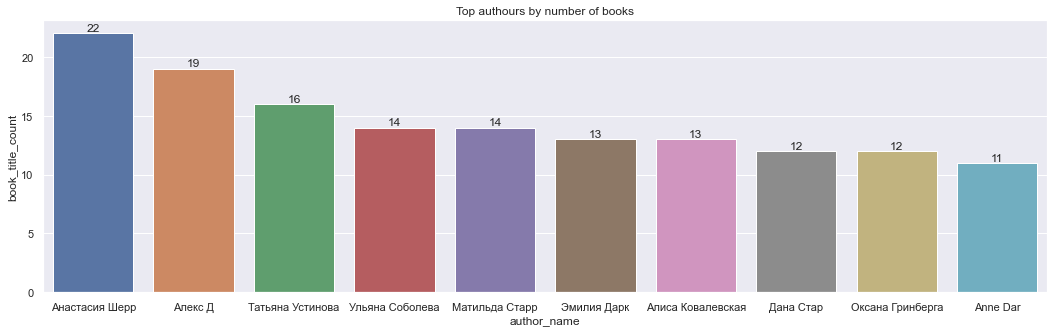

In [233]:
data = author_stat.sort_values("book_title_count", ascending=False)[:10]
sns.set(rc={'figure.figsize':(18,5)})
ax = sns.barplot(data=data, x="author_name", y="book_title_count")
for i in ax.containers:
    ax.bar_label(i,)
ax.set_title("Top authours by number of books")

**The most cited authors:** 

Text(0.5, 1.0, 'Top authours by number of quates')

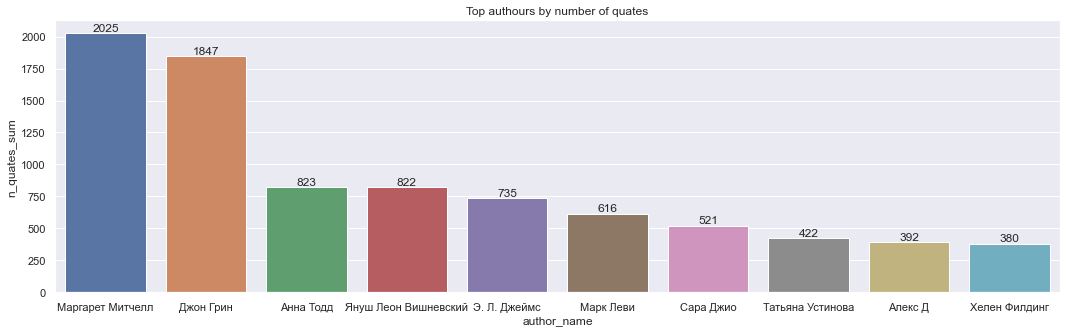

In [231]:
data = author_stat.sort_values("n_quates_sum", ascending=False)[:10]
sns.set(rc={'figure.figsize':(18,5)})
ax = sns.barplot(data=data, x="author_name", y="n_quates_sum")
for i in ax.containers:
    ax.bar_label(i,)
ax.set_title("Top authours by number of quates")

#### Stage 2.2: Price analisys

Text(0.5, 0.98, 'Price distribution')

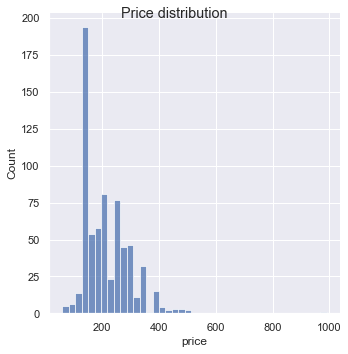

In [460]:
sns.set(rc={'figure.figsize':(18,5)})
p_mean = books_df["price"].mean()
p_median = books_df["price"].median()
p_mode = books_df["price"].mode()
ax = sns.displot(data=books_df.reset_index(), x="price")
ax.fig.suptitle("Price distribution")

In [350]:
print(f"Price: avgerage={int(p_mean)}, median={int(p_median)}, mode={int(p_mode)}")

Price: avgerage=213, median=199, mode=149


**Price / other indicator connection**

In [284]:
books_df["price_bin"] = pd.qcut(books_df.price, 10, duplicates="drop")

In [310]:
price_stat = books_df.groupby(["price_bin"]).agg(
    {"book_title":"count", "avg_score":"mean", "price":"mean", "n_quates":"mean", "n_reviews":"mean", "volume":"mean"}).reset_index()

In [313]:
price_stat.set_index("price", inplace=True)

Text(0.5, 1.0, 'Features over price')

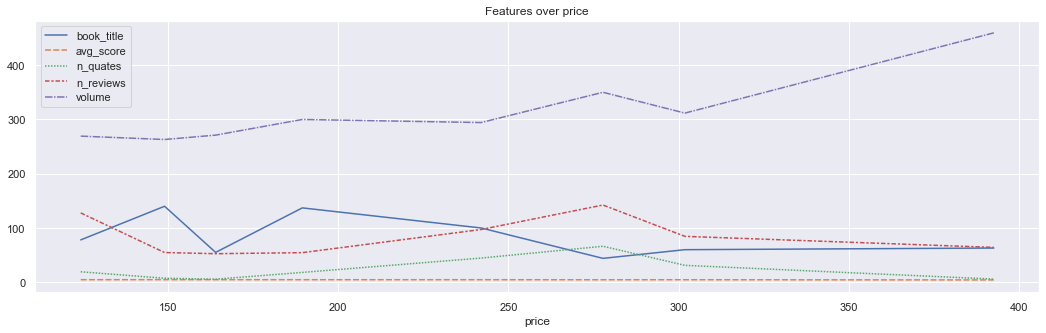

In [461]:
ax = sns.lineplot(data=price_stat)
ax.set_title("Features over price")

As we see the number of pages grows with the book price. The most scored and cited books cost from 250 to 300 rub.  

#### Stage 2.3: Tag analisys

List top 5 tags

In [339]:
from collections import defaultdict

tags = defaultdict(int)
for index, row in books_df.iterrows():
    for t in row["tags"]:
        tags[t] += 1

top_tags = defaultdict(list)
for t in tags:
    top_tags[tags[t]].append(t)

In [340]:
top_keys = list(top_tags.keys())
top_keys.sort(reverse = True)
top_keys = top_keys[:5]

In [352]:
for k in top_keys:
    print(f"{top_tags[k][0]}: {k} books")

любовные испытания: 205 books
романтическая эротика: 116 books
повороты судьбы: 110 books
страстная любовь: 87 books
страсть: 81 books


**Tags visualization**

In [418]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [419]:
tag_text = " ".join([" ".join(books_df["tags"].values[i]) for i in range(len(books_df["tags"].values))])

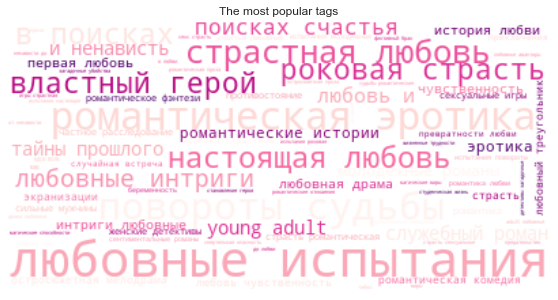

In [462]:
wordcloud = WordCloud(max_font_size=40, colormap='RdPu',background_color="white").generate(tag_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("The most popular tags")
plt.show()

**Books title visualization**

In [440]:
from pymystem3 import Mystem
text_title = " ".join(books_df["book_title"].values)
mystem = Mystem()
text_title = mystem.lemmatize(text_title)
text_lem = [w for w in text_title if " " not in w and len(w) > 2 and w != "для"]
text_lem =  " ".join([w for w in text_title if " " not in w and len(w) > 2 and w != "для"])
text_lem = text_lem.replace("оттенок","оттенков")

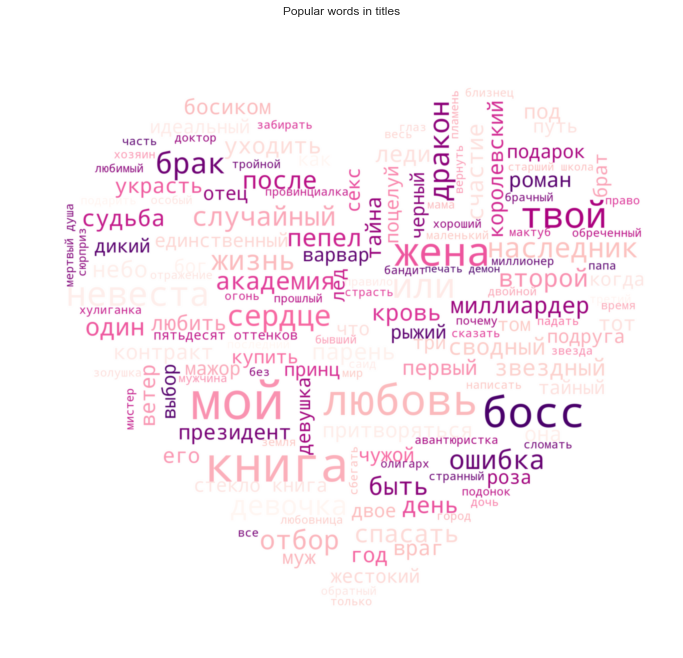

In [463]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

custom_mask = np.array(Image.open("heart.png"))
word_cloud = WordCloud(mask=custom_mask,
                       width=1600,
                       height=800,
                       colormap='RdPu',
                       margin=0,
                       max_words=500,
                       min_word_length=3,
                       max_font_size=150, min_font_size=30, 
                       background_color="white").generate(text_lem)

plt.figure(figsize=(12, 12))
plt.imshow(word_cloud, interpolation="gaussian")
plt.axis("off")
plt.title("Popular words in titles")
plt.show()